In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

In [ ]:
SAVE_ALL_PICTS = True # если надо сохранить все картинки

In [ ]:
# Не удаляйте, пожалуйста, я буду комменитровать после использования
# Не обращайте внимания, у меня почему то не работает так как задумано или я не понимаю :)

from google.colab import files
uploaded = files.upload()

registrations = pd.read_excel("Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='registrations')
print(registrations.shape) # (101930, 7)

visits = pd.read_excel("Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='visits')
print(visits.shape) # (58807, 2)

events = pd.read_excel("Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='events')
print(events.shape) # (5, 2)

(101930, 7)
(58807, 2)
(5, 2)


### 1. Читаем файлы

In [ ]:
registrations = pd.read_excel("Downloads\Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='registrations')
print(registrations.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'Downloads\\Кейс_Анализ Мероприятия Тех.xlsx'

In [ ]:
visits = pd.read_excel("Downloads\Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='visits')
print(visits.shape)

In [ ]:
events = pd.read_excel("Downloads\Кейс_Анализ Мероприятия Тех.xlsx", sheet_name='events')
print(events.shape)

### 2. Подготовка данных к работе

Дубликаты в visits предлагаю все-таки удалить (дубликаты по столбцу RegistrationID). У нас регистрация завязана на одного человека и на одно мероприятие, такие повторы могут свидетельствовать о возможных ошибках, связанных с двойным считыванием данных, или о том, что пользователи входили/выходили несколько раз.

In [ ]:
registrations["utm_source"] = registrations["utm_source"].fillna("organic")
registrations["utm_medium"] = registrations["utm_medium"].fillna("organic")
visits = visits.drop_duplicates(subset='RegistrationID') # удаляем дубликаты
print(f'Было 58_807 записи - стало {visits.shape[0]} записей\nУдалено: {58_807-visits.shape[0]} записей или {(1-visits.shape[0]/58_807)*100:.0f}%')

Было 58_807 записи - стало 36814 записей
Удалено: 21993 записей или 37%


Спорный момент: стоит ли удалять записи с регистрациями, где люди не указали свой класс. С одной стороны в эксель написано, что это ошибки выгрузки, и, конечно, проще всего просто избавиться от проблем: Но, есть и доводы в обратную сторону:
1. Если мы их удалим, то для EventID	= 15 у нас останется всего 4 записи (4, Карл!)
2. Я посмотрела эти данные и они слабо влияют на распределение посещаемости в других разрезах

Мы можем себе позволить потерять 800 записей из 100_000. Но мы можем их и оставить. Просто не учитывать в разрезе доходимости по классам (что matplotlib сам делает по умолчанию)

In [ ]:
# Тут просто джоиним таблицы
new_reg = registrations.merge(visits, on='RegistrationID', how='left')
print(new_reg.shape)
new_reg.head()

(101930, 8)


,RegistrationID,EventID,Who,Class,Created,utm_source,utm_medium,VisitID
0,30816,3,Родитель,10.0,2018-01-29 16:49:26,organic,organic,NaN
1,30817,3,Ученик,11.0,2018-01-29 23:56:02,organic,organic,11477.0
2,30818,3,Родитель,11.0,2018-01-29 23:56:07,organic,organic,NaN
3,30820,3,Ученик,10.0,2018-01-30 19:25:47,organic,organic,NaN
4,30822,3,Ученик,10.0,2018-02-02 11:04:25,organic,organic,NaN


Сразу посчитаем количество дней до мероприятия. Почему?
Тут 2 основных момента:
1. У нас есть люди, у которых дата регистрации идет позже даты визита (это странно, мы считаем это ошибками и сразу удаляем их)

2. У нас есть люди, у которых дата регистрации стоит позже 31-го дня. И да, согласно нашему эксель файлу, нам сказано, что "Регистрация на мероприятия начиналась за месяц..." (7 строка на 1 листе). Это спорный вопрос, стоит ли удалять этих людей. Потому что по итогу их около 16_000, а это почти 16% всех данных. С другой стороны, на доходимость в разрезах это удаление не влияет. Все расчеты я по итогу делала без этих "проблем".

3. Мой главный довод: распределения данных не меняются с добавлением этих странных товарищей, записавшихся сильно заранее. Просто при задании гипотез нам все равно придется их исключать, так зачем мучиться?

In [ ]:
# Сократим длинное название, для вывода на графиках (оно мне ранее просто портило графики, не обращайте внимания):
new_reg.loc[new_reg['utm_source'].str.contains('Mailigen', na=False), 'utm_source'] = 'Mailigen'

# Здесь джоиним последнюю таблицу
new_reg = new_reg.merge(events, left_on='EventID', right_on='ExhibitionID', how='left')

# Вычисляем сколько дней от регистрации до мероприятия
new_reg['DaysDiff'] = (new_reg['EventDate'] - pd.to_datetime(new_reg['Created'].dt.date)).dt.days

In [ ]:
#new_reg = new_reg[new_reg['DaysDiff'] >= 0]
new_reg = new_reg[(new_reg['DaysDiff'] > 0) & (new_reg['DaysDiff'] <= 35)] # 34 дня это ровно 5 недель (для удобства)
print(new_reg.shape)
new_reg.head()

(89450, 11)


,RegistrationID,EventID,Who,Class,Created,utm_source,utm_medium,VisitID,ExhibitionID,EventDate,DaysDiff
36,79069,3,Ученик,11.0,2018-09-27 20:17:22,organic,organic,NaN,3,2018-10-01,4
37,100705,17,Ученик,9.0,2019-01-17 13:14:31,organic,organic,NaN,17,2019-02-03,17
54,100034666,17,Ученик,10.0,2019-01-26 11:59:57,organic,organic,42956.0,17,2019-02-03,8
270,89543,17,Родитель,9.0,2019-01-05 17:26:17,organic,organic,39197.0,17,2019-02-03,29
271,90876,17,Родитель,10.0,2019-01-08 12:25:03,organic,organic,39717.0,17,2019-02-03,26


### 3. Исследуем доходимость (посещаемость)

In [ ]:
def get_attendance(by, df):
    """
    Функция считает количество регистраций/визитов и доходимость
        by - название столбца или их список, по которому/ым группируем данные
        df - датафрейм
        agg(sum_v = ('visits', 'sum'), )
    """
    df = df.groupby(by, as_index = False).agg({'RegistrationID':'count', 'VisitID':'count'}) \
               .rename(columns={'RegistrationID':'Registrations_count', 'VisitID':'Visits_count'})
    df['Attendance'] = df['Visits_count'] / df['Registrations_count'] * 100
    return df

def draw_attendance_hist(by, df, xlabel = '', title = 'Посещаемость', save=False, rotate=False):

    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    axes[0].bar(df[by], df['Attendance'], color='skyblue')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Посещаемость (%)')
    axes[0].set_title('График доходимости')
    axes[0].set_ylim(0, 100)

    axes[1].bar(df[by], df['Registrations_count'], color='skyblue')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Количество регистраций')
    axes[1].set_title('График активности')

    fig.suptitle(title)
    plt.tight_layout()

    if rotate:
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)
    if save:
        plt.savefig(title + '.png', format='png', dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
def get_attendance(by, df):
    """
    Функция считает количество регистраций/визитов и доходимость
        by - название столбца или их список, по которому/ым группируем данные
        df - датафрейм
        agg(sum_v = ('visits', 'sum'), )
    """
    df = df.groupby(by, as_index = False).agg({'RegistrationID':'count', 'VisitID':'count'}) \
               .rename(columns={'RegistrationID':'Registrations_count', 'VisitID':'Visits_count'})
    df['Attendance'] = df['Visits_count'] / df['Registrations_count'] * 100
    return df

def draw_attendance_hist(by, df, xlabel='', title='Посещаемость', save=False, rotate=False):
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))

    # Первый график: доходимость
    bars1 = axes[0].bar(df[by], df['Attendance'], color='skyblue')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel('Посещаемость (%)')
    axes[0].set_title('График доходимости')
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка

    # Добавляем проценты над столбцами (Проценты)
    for bar in bars1:
        height = bar.get_height()
        axes[0].annotate(f'{int(height)}%',  # Значение процента
                         xy=(bar.get_x() + bar.get_width() / 2, height),  # Координаты
                         xytext=(0, 3),  # Смещение текста
                         textcoords="offset points",
                         ha='center', va='bottom')

    # Второй график: количество регистраций
    bars2 = axes[1].bar(df[by], df['Registrations_count'], color='skyblue')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel('Количество регистраций')
    axes[1].set_title('График активности')
    axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка

    # # Добавляем значения над столбцами (Абсолюты)
    # for bar in bars2:
    #     height = bar.get_height()
    #     axes[1].annotate(f'{int(height)}',  # Значение регистраций
    #                      xy=(bar.get_x() + bar.get_width() / 2, height),
    #                      xytext=(0, 3),
    #                      textcoords="offset points",
    #                      ha='center', va='bottom')

    fig.suptitle(title)
    plt.tight_layout()

    if rotate:
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)
    if save:
        plt.savefig(title + '.png', format='png', dpi=100, bbox_inches='tight')
    plt.show()

**Доходимость по мероприятиям:**

,EventID,Registrations_count,Visits_count,Attendance
0,15,3705,823,22.213225
1,3,42728,16879,39.503370
2,17,27913,12326,44.158636
3,18,4139,1002,24.208746
4,20,10965,2905,26.493388


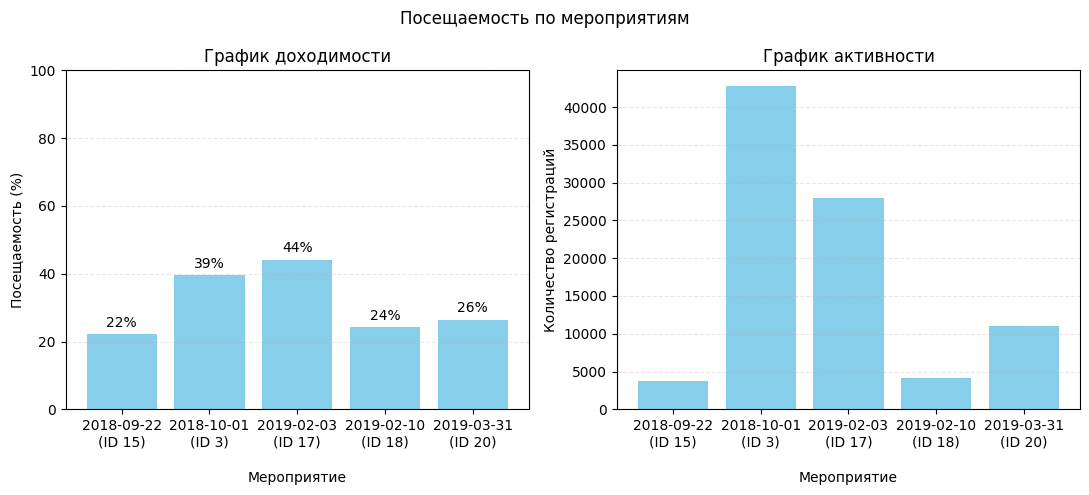

In [ ]:
df = get_attendance(by='EventID', df=new_reg)
df = df.merge(events, left_on='EventID', right_on='ExhibitionID').sort_values('EventDate').reset_index(drop=True)
df['EventName'] = df['EventDate'].astype(str) + '\n(ID ' + df['EventID'].astype(str) + ')\n'
display(df.iloc[:, :4])

draw_attendance_hist(by='EventName', df=df, xlabel='Мероприятие', title='Посещаемость по мероприятиям', save=SAVE_ALL_PICTS)

**Доходимость ученик/родитель:**

,Who,Registrations_count,Visits_count,Attendance
0,Другое,154,34,22.077922
1,Родитель,30873,11156,36.135134
2,Ученик,58423,22745,38.931585


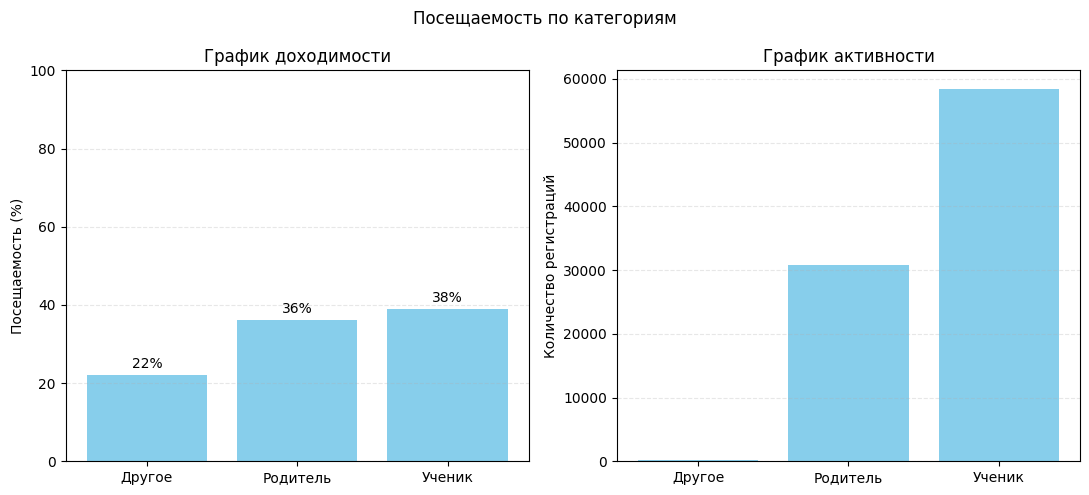

In [ ]:
df = get_attendance(by='Who', df=new_reg)
display(df)
draw_attendance_hist(by='Who', df=df, xlabel='', title='Посещаемость по категориям', save=SAVE_ALL_PICTS)

**Доходимость класс**

In [ ]:
df = get_attendance(by='Class', df=new_reg)
df['Class'] = df['Class'].astype('int32').astype(str)

display(df)

,Class,Registrations_count,Visits_count,Attendance
0,1,514,162,31.517510
1,2,146,24,16.438356
2,3,201,45,22.388060
3,4,314,53,16.878981
4,5,620,133,21.451613
5,6,2097,574,27.372437
6,7,3820,1083,28.350785
7,8,7958,2773,34.845439
8,9,16613,6372,38.355505
9,10,20904,8897,42.561232


,Class,Registrations_count,Visits_count,Attendance
0,1,514,162,31.517510
1,2,146,24,16.438356
2,3,201,45,22.388060
3,4,314,53,16.878981
4,5,620,133,21.451613
5,6,2097,574,27.372437
6,7,3820,1083,28.350785
7,8,7958,2773,34.845439
8,9,16613,6372,38.355505
9,10,20904,8897,42.561232


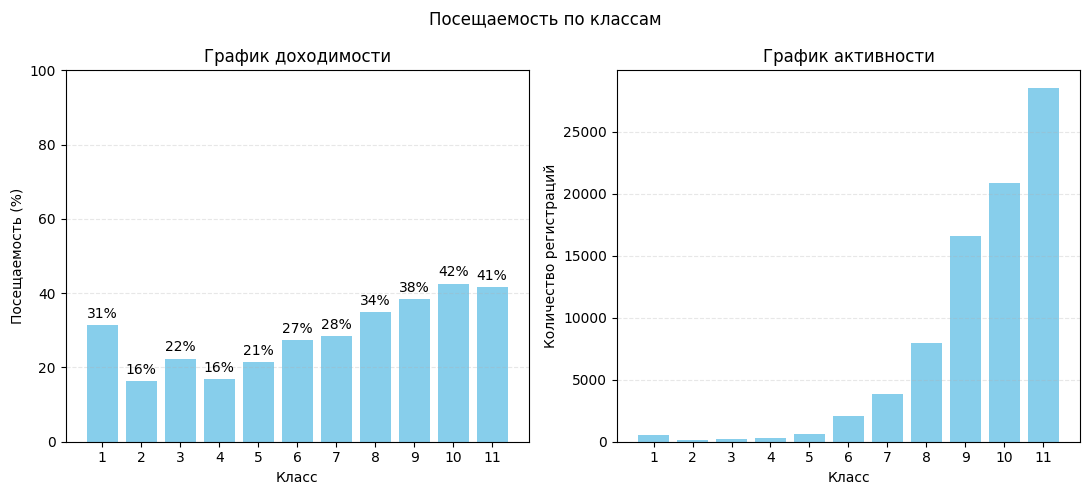

In [ ]:
df = get_attendance(by='Class', df=new_reg)
df['Class'] = df['Class'].astype('int32').astype(str)

display(df)
draw_attendance_hist(by='Class', df=df, xlabel='Класс', title='Посещаемость по классам', save=SAVE_ALL_PICTS)
# по умолчанию plt.bar() выкидывает все Nan

**Доходимость utm_source**

1789.0


,utm_source,Registrations_count,Visits_count,Attendance
43,yandex,2790,1443,51.720430
23,organic,30380,14975,49.292298
26,propostuplenie,10435,3896,37.335889
1,Mailigen,7372,2695,36.557244
37,vk,8139,2665,32.743580
10,fb,24022,6144,25.576555
14,import,1814,453,24.972437
7,Другое,4498,1664,36.994220


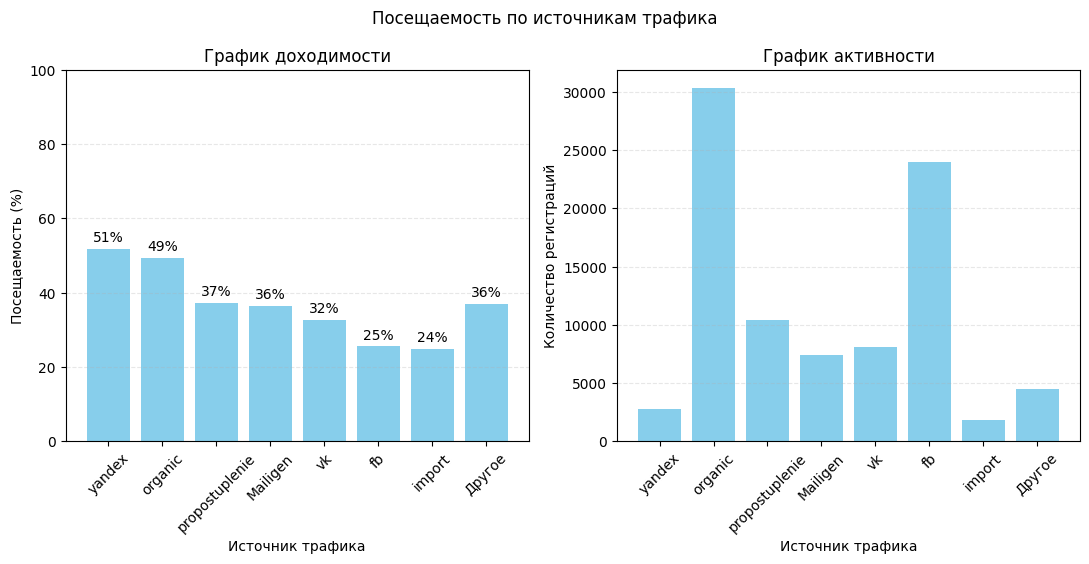

In [ ]:
df = get_attendance(by='utm_source', df=new_reg)

# если кол-во регистраций меньше 2,5% от общего числа то соотносим это в отдельную общую категорию - Другое
border = df['Registrations_count'].sum()*0.02
print(border)

small_groups = df[df['Registrations_count'] < border].sum()
df = df[df['Registrations_count'] >= border].sort_values(by='Attendance', ascending=False)

df.loc[len(df)] = ['Другое', small_groups['Registrations_count'], small_groups['Visits_count'],
                   small_groups['Visits_count'] / small_groups['Registrations_count'] * 100]

display(df)
draw_attendance_hist(by='utm_source', df=df, xlabel='Источник трафика', title='Посещаемость по источникам трафика', save=SAVE_ALL_PICTS, rotate=True)

Обратите внимание на таблицу с абсолютными величинами. Яндекс хорош, но поток регистраций оттуда небольшой (вероятно, заказчик мало закупает рекламы).  
Лучше всего - органик (т.е. люди попали без рекламы, просто заранее искали сайт заказчика/вышли на него из поиска). Логично, что они будут наиболее заинтересованы.  
Facebook довольно плох. Судя по количеству регистраций деньги туда тратятся неплохие, а вот результат с этого небольшой (25% это не 0%, конечно, но довольно низко относительно остального).

**Доходимость в связке:**

1789.0


,utm_source,utm_medium,Registrations_count,Visits_count,Attendance,utm_source + utm_medium
95,yandex,cpc,2727,1412,51.778511,yandex + cpc
33,organic,organic,30380,14975,49.292298,organic + organic
56,propostuplenie,banner,10106,3771,37.314467,propostuplenie + banner
1,Mailigen,email,7232,2642,36.532080,Mailigen + email
75,vk,cpc,4891,1353,27.663055,vk + cpc
14,fb,cpa,23773,6045,25.428007,fb + cpa
21,import,form,1814,453,24.972437,import + form
7,Другое,Другое,8527,3284,38.512959,Другое


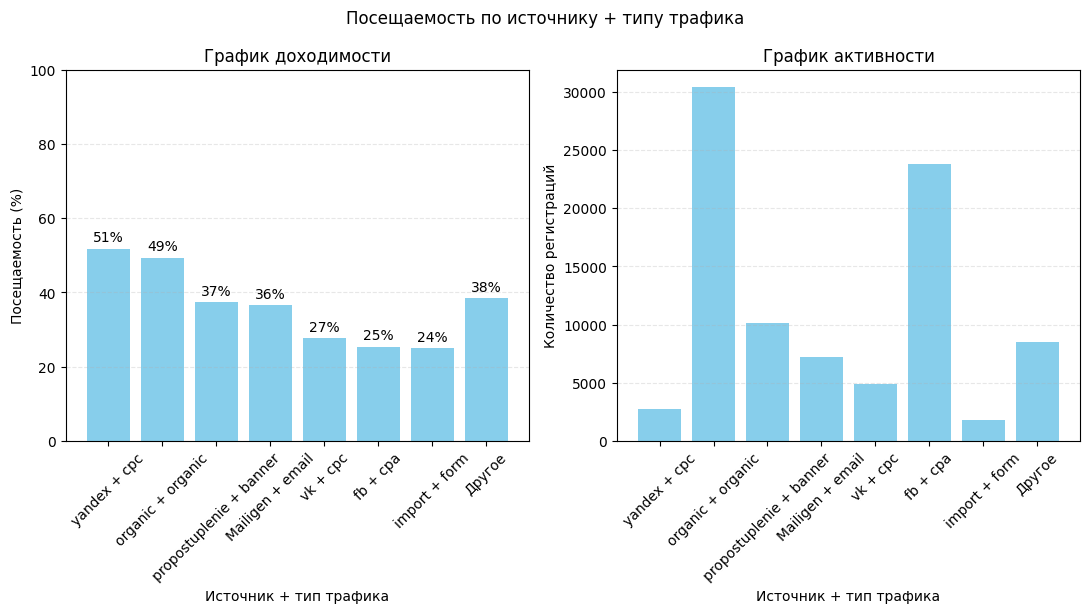

In [ ]:
df = get_attendance(by=['utm_source', 'utm_medium'], df=new_reg)
#df.to_csv('results.csv')

df['utm_source + utm_medium'] = df['utm_source'] + ' + ' + df['utm_medium']
border = df['Registrations_count'].sum()*0.02
print(border)

small_groups = df[df['Registrations_count'] < border].sum()
df = df[df['Registrations_count'] >= border].sort_values(by='Attendance', ascending=False)

df.loc[len(df)] = ['Другое', 'Другое', small_groups['Registrations_count'], small_groups['Visits_count'],
                   small_groups['Visits_count'] / small_groups['Registrations_count'] * 100, 'Другое']

display(df)
draw_attendance_hist(by='utm_source + utm_medium', df=df, xlabel='Источник + тип трафика',
                     title='Посещаемость по источнику + типу трафика', save=SAVE_ALL_PICTS, rotate=True)

Может, в этом и проблема facebook. У него основной тип трафика cpa - плата за показы. Т.е. он заинтересован в показе рекламы как таковой (а вот превратится ли она в целевое действие - не очень).

### 4. Гипотеза 1: Возможно, посещаемость зависит от даты регистрации?  

In [ ]:
def draw_lineplot(by, df, title='', save=False, show=True):
    """
        График слева - количество регистраций по..
        График справа - доходимость по..
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.lineplot(data=df, x=by, y='Registrations_count', ax=axes[1])
    axes[1].set_ylabel('Количество регистраций')
    axes[1].set_title('График активности')

    axes[0].grid(alpha=0.3)  # Cетка для 1го графика
    axes[1].grid(alpha=0.3)  # Ceтка для 2го графика

    sns.lineplot(data=df, x=by, y='Attendance', ax=axes[0])
    axes[0].set_ylabel('Посещаемость (%)')
    axes[0].set_title('График доходимости')

    fig.suptitle(title)
    plt.tight_layout()
    if save:
        plt.savefig(title + '.png', format='png', dpi=100, bbox_inches='tight')
    if show:
        plt.show()

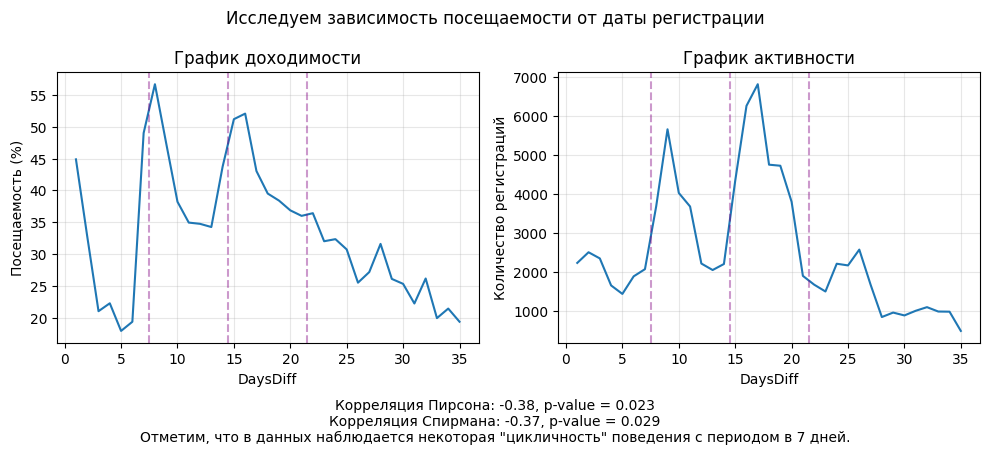

In [ ]:
df = get_attendance('DaysDiff', new_reg)
res = stats.pearsonr(df['DaysDiff'], df['Attendance'])
res2 = stats.spearmanr(df['DaysDiff'], df['Attendance'])

draw_lineplot('DaysDiff', df, title='Исследуем зависимость посещаемости от даты регистрации', show=False)
fig = plt.gcf()
ax = fig.get_axes()
for i in range(2):
    ax[i].axvline(x=7.5, color='purple', linestyle='--', alpha=0.4)
    ax[i].axvline(x=14.5, color='purple', linestyle='--', alpha=0.4)
    ax[i].axvline(x=21.5, color='purple', linestyle='--', alpha=0.4)
text = f"""
Корреляция Пирсона: {res[0]:.2f}, p-value = {res[1]:.3f}\nКорреляция Спирмана: {res2[0]:.2f}, p-value = {res2[1]:.3f}\nОтметим, что в данных наблюдается некоторая "цикличность" поведения с периодом в 7 дней.
"""
fig.text(0.5, -0.05, text, ha='center', va='center', wrap=True)
if SAVE_ALL_PICTS:
    plt.savefig('По дням без сглаживания.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

**Сгладим тренд по неделям!**  
Попробуем сгладить данные по неделям, чтобы учесть цикличные пики/спады

,N_of_week,Registrations_count,Visits_count,Attendance
0,0,10202,2951,28.925701
1,1,23254,9759,41.966973
2,2,31156,13776,44.216202
3,3,15859,5225,32.946592
4,4,7496,1916,25.560299
5,5,1483,308,20.768712


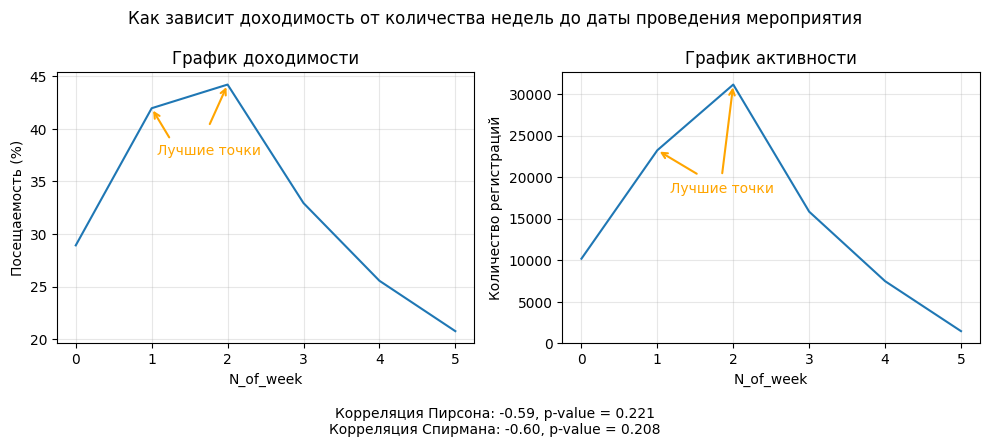

In [ ]:
# Номер недели относительно даты проведения мероприятия:
new_reg['N_of_week'] = (new_reg['DaysDiff'] + 1) // 7
df = get_attendance(by='N_of_week', df=new_reg)

res = stats.pearsonr(df['N_of_week'].astype(int), df['Attendance'])
res2 = stats.spearmanr(df['N_of_week'].astype(int), df['Attendance'])

display(df)
df['N_of_week'] = df['N_of_week'].astype(str)
draw_lineplot(by='N_of_week', df=df, title='Как зависит доходимость от количества недель до даты проведения мероприятия', show=False)

fig = plt.gcf()
ax = fig.get_axes()

# стрелочки для правого графика
x, y = df.iloc[2, [0, 3]].values
x = int(x)
ax[0].annotate('', xy=(x, y), xytext=(x-0.25, y-4),arrowprops=dict(arrowstyle='->', lw=1.5, color='orange'))
ax[0].text(x-0.25, y - 6.7, 'Лучшие точки', ha='center', fontsize=10, color='orange')

x, y = df.iloc[1, [0, 3]].values
x = int(x)
ax[0].annotate('', xy=(x, y), xytext=(x+0.25, y-3),arrowprops=dict(arrowstyle='->', lw=1.5, color='orange'))

# стрелочки для левого графика
x, y = df.iloc[2, [0, 1]].values
x = int(x)
ax[1].annotate('', xy=(x, y), xytext=(x-0.15, y-11000),arrowprops=dict(arrowstyle='->', lw=1.5, color='orange'))
ax[1].text(x - 0.15, y - 13000, 'Лучшие точки', ha='center', fontsize=10, color='orange')

x, y = df.iloc[1, [0, 1]].values
x = int(x)
ax[1].annotate('', xy=(x, y), xytext=(x+0.55, y-3000),arrowprops=dict(arrowstyle='->', lw=1.5, color='orange'))

text=f'Корреляция Пирсона: {res[0]:.2f}, p-value = {res[1]:.3f}\nКорреляция Спирмана: {res2[0]:.2f}, p-value = {res2[1]:.3f}'
#text = "Почему мы наблюдаем то, что наблюдаем?\n1. Очные мероприятия могут быть неудобны для участников, зарегистрировавшихся накануне.\n2. Регистрация за 3-4 недели до события приводит к потерям интереса.\n3. Оптимальный срок для регистрации — 1-2 недели до мероприятия (7-20 дней до начала)."
fig.text(0.5, -0.05, text, ha='center', va='center', wrap=True)
if SAVE_ALL_PICTS:
    plt.savefig('По дням после сглаживания.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
# Корреляция (Пирсон - Кендалл - Спирман):
# 0.42 0.38 0.38 без сглаживания
# 0.48 0.4 0.6 после сглаживания по неделям
print(res)
print(res2)
# т.к. pvalue большое, нулевая гипотеза не отвергается т.е. строгой линейной/монотонной зависимости установить не удалось (по крайней мере стат значимо)

PearsonRResult(statistic=-0.5867552824501806, pvalue=0.2208716474254868)
SignificanceResult(statistic=-0.6, pvalue=0.20799999999999982)


**Какие можно сделать выводы:**
1. Помним, что все мероприятия очные! Т.е. людям не очень удобно идти на мероприятие, на которое они записались накануне (незаконченные дела, время не удалось выделить и вообще морально не готов - лень идти)
2. Но и слишком рано приведенные слушатели, т.е. за 3-4 недели до мероприятия, банально теряют интерес/забывают
3. Оптимально: 1-2 недели до мероприятия (т.е. 7-20 дни до начала)

### 4. Гипотеза 2: Возможно, посещаемость зависит дня недели?

In [ ]:
# 0 - Понедельник
# 6 - Воскресение
new_reg['Weekday'] = new_reg['Created'].dt.weekday.astype(int)

,Weekday,Registrations_count,Visits_count,Attendance
0,0,6725,2252,33.486989
1,1,8865,2853,32.182741
2,2,11231,3803,33.861633
3,3,12435,4434,35.657419
4,4,15224,5897,38.734892
5,5,13858,6920,49.935056
6,6,6940,3440,49.567723


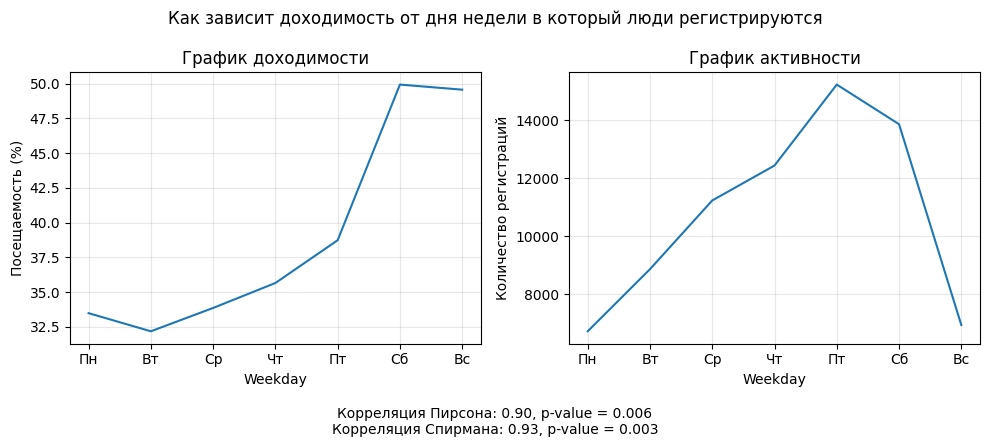

In [ ]:
# Почему мы берем только дни через неделю после мероприятий объяснено в выводах ниже
df = get_attendance(by='Weekday', df=new_reg[new_reg['DaysDiff'] > 7])
display(df)
res = stats.pearsonr(df['Weekday'].astype(int), df['Attendance'])
res2 = stats.spearmanr(df['Weekday'].astype(int), df['Attendance'])

days_dict = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
df['Weekday'] = df['Weekday'].map(days_dict)
draw_lineplot(by='Weekday', df=df, title='Как зависит доходимость от дня недели в который люди регистрируются', save=False, show=False)

fig = plt.gcf()
text=f'Корреляция Пирсона: {res[0]:.2f}, p-value = {res[1]:.3f}\nКорреляция Спирмана: {res2[0]:.2f}, p-value = {res2[1]:.3f}'
fig.text(0.5, -0.05, text, ha='center', va='center', wrap=True)
if SAVE_ALL_PICTS:
    plt.savefig('Как зависит доходимость от дня недели в который люди регистрируются.png', dpi=100, bbox_inches='tight')
plt.show()

**Какие можно сделать выводы:**
1. Мы брали только людей с датами за неделю и более до мероприятия чтобы исключить корреляцию с близостью даты мероприятия (т.е. если мероприятие в воскресение, то наплыв людей в пятницу скорее объяснен этим фактором). *P.S. даже если взять все даты - зависимость не изменится.*

2. Наиболее сильно люди интересуются мероприятиями заказчика в пятницу-субботу, а наибольшая конверсия у нас в субботу-воскресение. Т.е. самые оптимальные дни для рекламы - пятница-суббота. Особенно суббота.

Мы, кстати, сейчас посмотрим и покажем, почему у facebook несмотря на довольно высокие показатели количества регистраций (предположительно заказчик тратит много денег на рекламу там) соответствуют довольно средним показателям по конверсии (т.е. доходимости: превращении регистрации в визит на мероприятие). А тот же яндекс показывает себя получше.

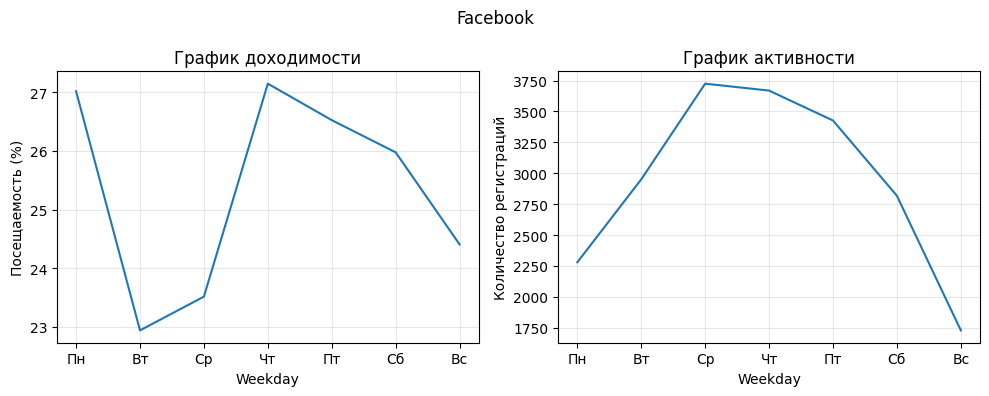

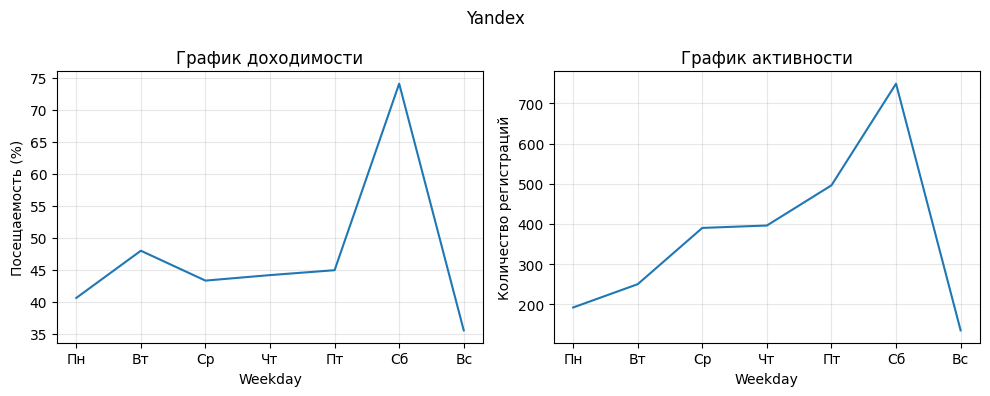

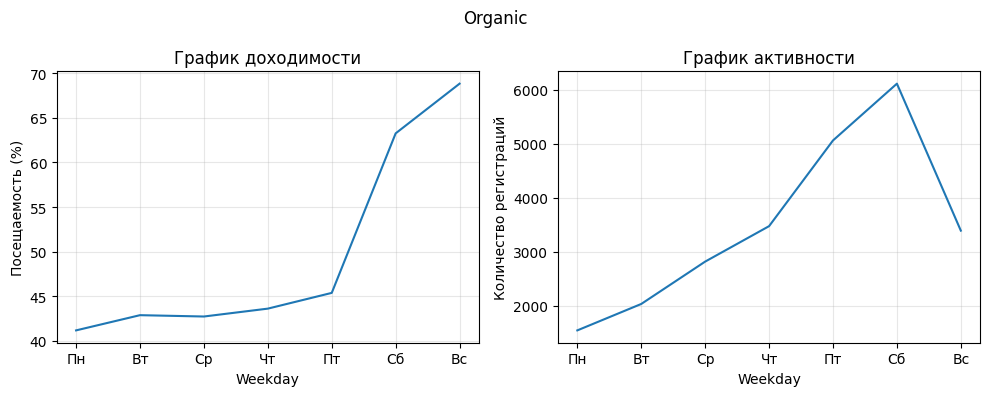

In [ ]:
df = get_attendance(by='Weekday', df=new_reg[(new_reg['DaysDiff'] > 7) & (new_reg['utm_source'] == 'fb')])
df['Weekday'] = df['Weekday'].map(days_dict)
draw_lineplot(by='Weekday', df=df, title='Facebook', save=SAVE_ALL_PICTS)

df = get_attendance(by='Weekday', df=new_reg[(new_reg['DaysDiff'] > 7) & (new_reg['utm_source'] == 'yandex')])
df['Weekday'] = df['Weekday'].map(days_dict)
draw_lineplot(by='Weekday', df=df, title='Yandex', save=SAVE_ALL_PICTS)

df = get_attendance(by='Weekday', df=new_reg[(new_reg['DaysDiff'] > 7) & (new_reg['utm_source'] == 'organic')])
df['Weekday'] = df['Weekday'].map(days_dict)
draw_lineplot(by='Weekday', df=df, title='Organic', save=SAVE_ALL_PICTS)

* Facebook приводит много людей по средам-пятницам (когда конверсия ну так себе) и очень мало в самый выигрышный для нас день - субботу!  
* Яндекс как раз целит свою рекламу в основном на пятницу-субботу и имеет с этого хорошую конверсию.  

Плюс, яндекс - это айти гигант, который хорошо отслеживает нашу геолокацию и может точнее нацелить рекламу (не забываем, все наши мероприятия очные, мало кто захочет поехать ради них в другой город или дальний район). Это косвенно подтверждается высокой конверсией у похожего на него гугла (но там мало регистраций как таковых, поэтому он нигде выше не фигурирует)

### Проверим гипотезу:  
Нулевая гипотеза: Посещаемость с фейсбука такая же как с яндекса и органического трафика  
Альтернативная гипотеза: Посещаемость с фейсбука хуже

In [ ]:
to_compare = ['organic', 'propostuplenie', 'fb', 'yandex', 'vk', 'Mailigen']
get_attendance('utm_source', new_reg[(new_reg['EventID'] == 17) & (new_reg['utm_source'].isin(to_compare))])

,utm_source,Registrations_count,Visits_count,Attendance
0,Mailigen,2990,1075,35.953177
1,fb,6458,2031,31.449365
2,organic,9410,5328,56.620616
3,propostuplenie,3073,1360,44.256427
4,vk,2171,806,37.125749
5,yandex,907,574,63.285557


In [ ]:
for n in [3, 17, 15, 18, 20]:
    df = get_attendance('utm_source', new_reg[(new_reg['EventID'] == n) & (new_reg['utm_source'].isin(to_compare))])
    p_val = []
    alpha = 0.01

    for i in [0, 2, 3, 4, 5]:
        successes = np.array([df.loc[1, 'Visits_count'], df.loc[i, 'Visits_count']])
        trials = np.array([df.loc[1, 'Registrations_count'], df.loc[i, 'Registrations_count']])
        _, p = sm.stats.proportions_ztest(successes, trials, alternative='smaller')
        p_val.append(p)

    reject, pval_corrected, _, _ = multipletests(p_val, alpha=alpha, method='bonferroni') #'fdr_bh' 'bonferroni'
    print("Отвергнуты ли нулевые гипотезы с поправкой:", reject)

Отвергнуты ли нулевые гипотезы с поправкой: [ True  True  True  True  True]
Отвергнуты ли нулевые гипотезы с поправкой: [ True  True  True  True  True]
Отвергнуты ли нулевые гипотезы с поправкой: [False  True  True False False]
Отвергнуты ли нулевые гипотезы с поправкой: [ True  True False False  True]
Отвергнуты ли нулевые гипотезы с поправкой: [ True False  True False  True]


* Таким образом, удалось отвергнуть нулевую гипотезу для источников: Mailigen, organic, propostuplenie и yandex.  
* Но не удалось подтвердить для vk.

### 4. Гипотеза 3: Возможно, есть определенные часы, в которые люди лучше обращаются в участников мероприятий?
Это скорее вопрос сохранения денег: сократить время показа рекламы до самых релевантных часов.

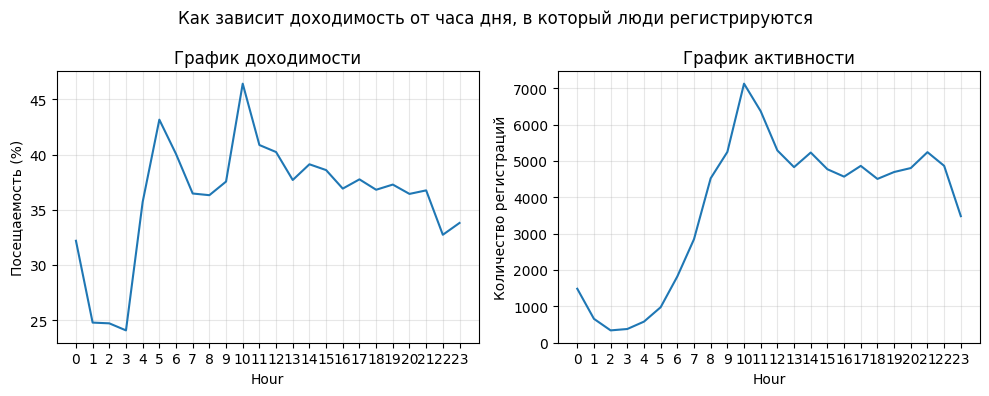

In [ ]:
new_reg['Hour'] = new_reg['Created'].dt.hour.astype(int)
df = get_attendance(by='Hour', df=new_reg)

#display(df)
df['Hour'] = df['Hour'].astype(str)
draw_lineplot(by='Hour', df=df, title='Как зависит доходимость от часа дня, в который люди регистрируются', save=SAVE_ALL_PICTS)

In [ ]:
# Корреляция (Пирсон - Кендалл - Спирман):
# 0.32 0.015 0.16
# линейная/мотононная сязь статистически незначима
print(stats.pearsonr(df['Hour'].astype(int), df['Attendance']))
print(stats.spearmanr(df['Hour'].astype(int), df['Attendance']))

PearsonRResult(statistic=0.31843067870439123, pvalue=0.12939294583485952)
SignificanceResult(statistic=0.18086956521739128, pvalue=0.39767420741690407)


* В общем, оптимальные часы: с 9 утра до 21 вечера.
* А в 10-11 часов у нас вообще пик по активности и конверсии.

### 5. Исследование мероприятий по отдельности

In [ ]:
def get_analyz_by(dataframe, ids=[3, 17], palette='pastel'):
    """Функция выводи сразу 3 графика по анализу мероприятий друг с другом
        df - датафрейм
        ids - список id мероприятий для сравнения
    """
    # график первый:
    df = get_attendance(by='EventID', df=dataframe[dataframe['EventID'].isin(ids)])
    df['EventID'] = df['EventID'].astype(str)

    tmp = get_attendance(by='EventID', df=new_reg)
    avg_attendance = tmp['Attendance'].mean()

    # avg_attendance = df['Visits_count'].sum() / df['Registrations_count'].sum() * 100
    avg_registrations_count = tmp['Registrations_count'].mean()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_title('Доходимость')
    axes[1].set_title('Активность')
    axes[0].set_ylabel('Посещаемость (%)')  # Изменено
    axes[1].set_ylabel('Количество регистраций')  # Изменено
    axes[0].axhline(y=avg_attendance, color='red', linestyle='--', label=f'Средняя доходимость: {avg_attendance:.2f}%')
    sns.barplot(df, x='EventID', y='Attendance', color='skyblue', ax=axes[0])
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка
    axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка

    axes[1].axhline(y=avg_registrations_count, color='red',
                    linestyle='--', label=f'Среднее кол-во регистраций {avg_registrations_count:.0f}')

    sns.barplot(df, x='EventID', y='Registrations_count', color='skyblue', ax=axes[1])

    # Добавляем проценты на график доходимости
    for i, row in df.iterrows():
        axes[0].text(i, row['Attendance'] + 2, f"{row['Attendance']:.0f}%", ha='center', va='bottom', fontsize=9)

    # # График активности
    # sns.barplot(df, x='EventID', y='Registrations_count', color='skyblue', ax=axes[1])
    # axes[1].grid(axis='y', linestyle='--', alpha=0.3)

    # # Добавляем проценты на график активности
    # for i, row in df.iterrows():
    #     axes[1].text(i, row['Registrations_count'] + 2, f"{row['Registrations_count']:.0f}", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    if SAVE_ALL_PICTS:
        plt.savefig('p1.png', format='png', dpi=100, bbox_inches='tight')
    plt.show()

    # график второй:
    tmp = get_attendance(by='Who', df=new_reg)

    parents_avg = tmp.loc[tmp['Who'] == 'Родитель', 'Attendance'].values[0]
    children_avg = tmp.loc[tmp['Who'] == 'Ученик', 'Attendance'].values[0]

    parents_avg_registrations = tmp.loc[tmp['Who'] == 'Родитель', 'Registrations_count'].values[0] / 5
    children_avg_registrations = tmp.loc[tmp['Who'] == 'Ученик', 'Registrations_count'].values[0] / 5


    df = get_attendance(by=['Who', 'EventID'], df=dataframe[(dataframe['Who'] != 'Другое') & (dataframe['EventID'].isin(ids))])
    # parents_avg = df[df['Who'] == 'Родитель']['Visits_count'].sum() / df[df['Who'] == 'Родитель']['Registrations_count'].sum() * 100
    # children_avg = df[df['Who'] == 'Ученик']['Visits_count'].sum() / df[df['Who'] == 'Ученик']['Registrations_count'].sum() * 100

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_title('Доходимость')
    axes[1].set_title('Активность')
    axes[0].set_ylabel('Посещаемость (%)')
    axes[1].set_ylabel('Количество регистраций')
    sns.barplot(df, x='Who', y='Attendance', hue='EventID', palette=palette, ax = axes[0])
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка
    axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка
    axes[0].axhline(y=parents_avg, xmax=0.5, color='blue', linestyle='--', alpha=0.5)
    axes[0].axhline(y=children_avg, xmin=0.5, color='blue', linestyle='--', alpha=0.5)
    axes[0].hlines(y=0, xmin=0, xmax=0,  colors='blue', linestyles='--', label=f'Средняя для каждой категории')
    axes[1].hlines(y=0, xmin=0, xmax=0,  colors='blue', linestyles='--', label=f'Средняя активность для каждой категории')

    axes[1].axhline(y=parents_avg_registrations, xmax=0.5, color='blue', linestyle='--', alpha=0.5)
    axes[1].axhline(y=children_avg_registrations, xmin=0.5, color='blue', linestyle='--', alpha=0.5)

    axes[0].legend()
    sns.barplot(df, x='Who', y='Registrations_count', hue='EventID', palette=palette, ax=axes[1])

    # Добавляем проценты на график доходимости
    for i, bar in enumerate(axes[0].patches):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width() / 2, height + 2, f"{height:.0f}%",
                     ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    if SAVE_ALL_PICTS:
        plt.savefig('p2.png', format='png', dpi=100, bbox_inches='tight')
    plt.show()

    # график третий:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_title('Доходимость')
    axes[1].set_title('Активность')
    axes[0].set_ylabel('Посещаемость (%)')
    axes[1].set_ylabel('Количество регистраций')
    df = get_attendance(by=['Class', 'EventID'], df=dataframe[dataframe['EventID'].isin(ids)])
    df['Class'] = df['Class'].astype(int).astype(str)
    sns.barplot(df, x='Class', y='Attendance', hue='EventID', palette=palette, ax=axes[0])
    axes[0].set_ylim(0, 100)
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка
    axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка

    tmp = get_attendance(by='Class', df=new_reg)
    tmp['Class'] = tmp['Class'].astype('int32').astype(str)
    # display(tmp)

    for i in range(11):
        avg = tmp.loc[tmp['Class'] == str(i + 1), 'Attendance'].values[0]
        avg_reg = tmp.loc[tmp['Class'] == str(i + 1), 'Registrations_count'].values[0] / 5

        #axes[0].axhline(y=avg, xmin=i * 1 / 11, xmax=(i + 1) / 11, color='blue', linestyle='--', alpha=0.5)
        #axes[1].axhline(y=avg_reg, xmin=i * 1 / 11, xmax=(i + 1) / 11, color='blue', linestyle='--', alpha=0.5)
        axes[0].axhline(y=avg, xmin=1 / 24 + i * 1 / 12, xmax=1 / 24 + (i + 1) / 12, color='blue', linestyle='--', alpha=0.5)
        axes[1].axhline(y=avg_reg, xmin=1 / 24 + i * 1 / 12, xmax=1 / 24 + (i + 1) / 12, color='blue', linestyle='--', alpha=0.5)

    # for i in range (11):
    #     avg = df[df['Class'] == str(i + 1)]['Visits_count'].sum() / df[df['Class'] == str(i + 1)]['Registrations_count'].sum() * 100
    #     axes[0].axhline(y=avg, xmin = i*1/11, xmax=(i+1)/11, color='blue', linestyle='--')

    axes[0].hlines(y=0, xmin=0, xmax=0,  colors='blue', linestyles='--', label=f'Средняя доходимость для каждого класса')
    axes[1].hlines(y=0, xmin=0, xmax=0,  colors='blue', linestyles='--', label=f'Средняя активность для каждого класса')
    sns.barplot(df, x='Class', y='Registrations_count', hue='EventID', palette=palette, ax=axes[1])
    axes[0].legend()
    plt.tight_layout()
    if SAVE_ALL_PICTS:
        plt.savefig('p3.png', format='png', dpi=100, bbox_inches='tight')
    plt.show()

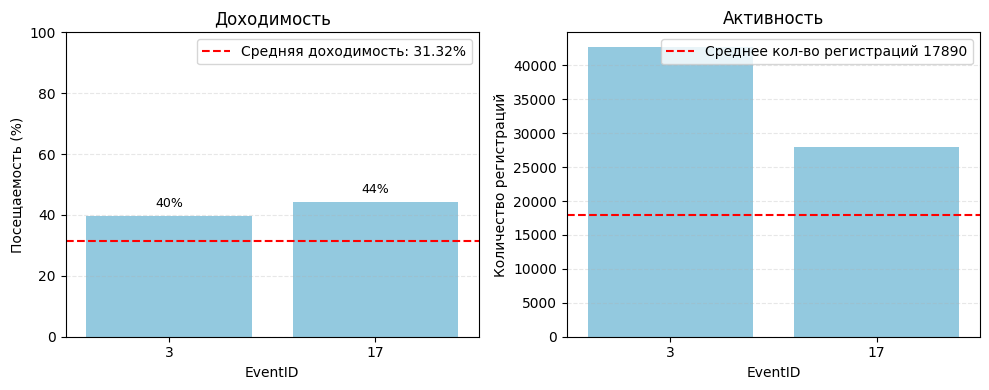

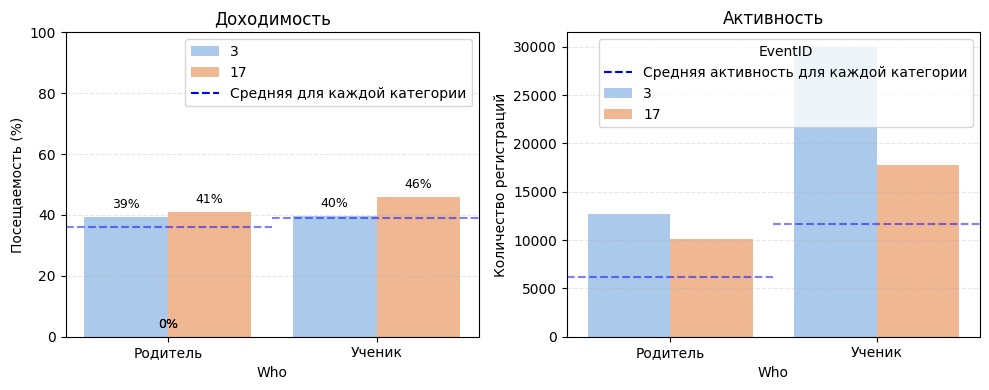

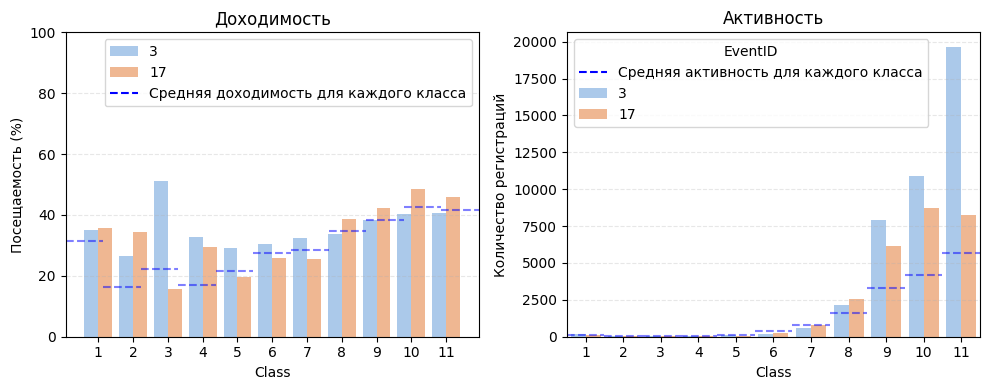

In [ ]:
get_analyz_by(new_reg, [3, 17])

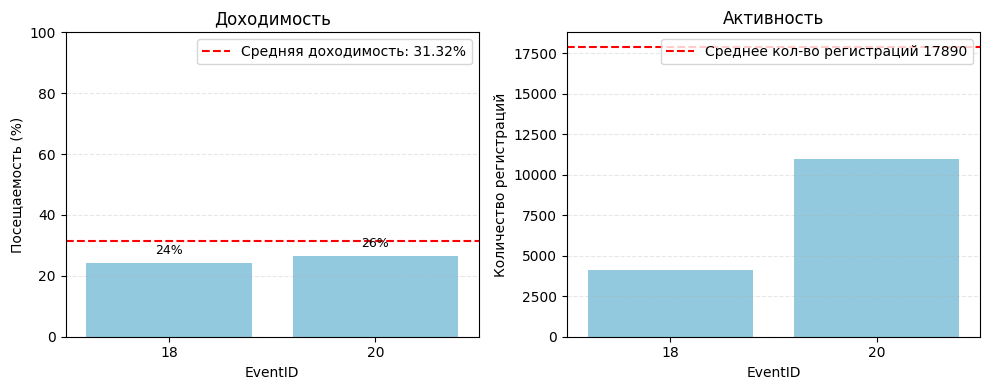

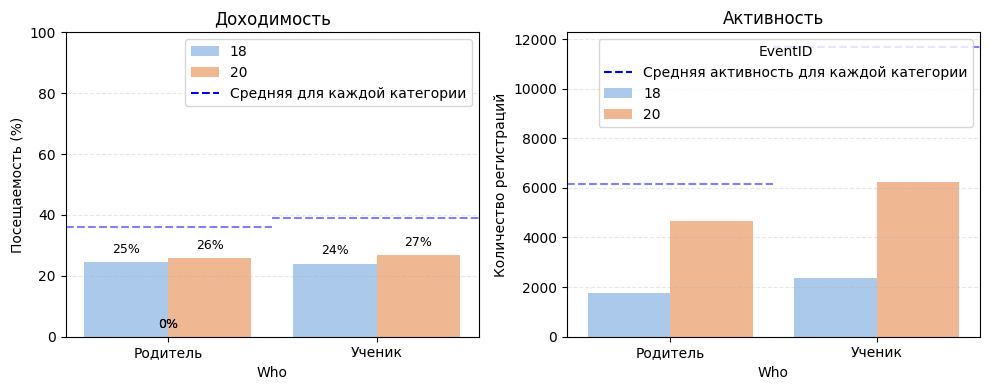

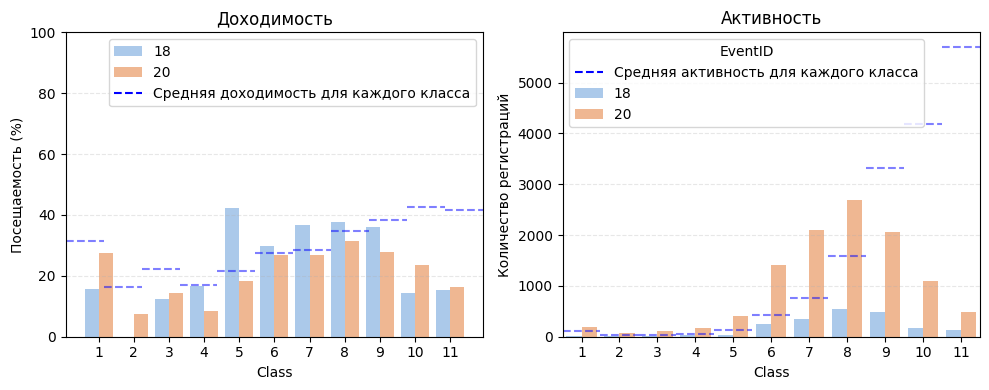

In [ ]:
get_analyz_by(new_reg, [18, 20])

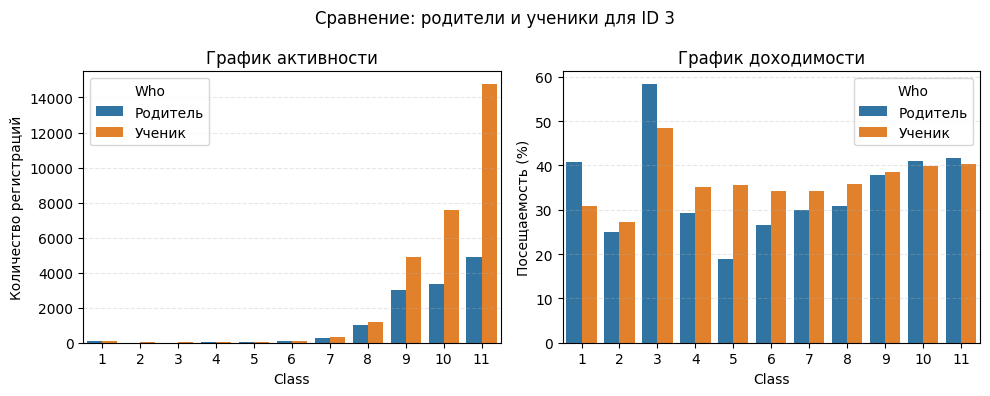

In [ ]:
# Порассматриваем ситуацию с классами поближе:
for_event = 3 # ставьте сюда айди мероприятия и смотрите

df = get_attendance(by=['Who', 'Class'], df=new_reg[(new_reg['Who'] != 'Другое') & (new_reg['EventID'].isin([for_event]))])
df = df[df['Class'] <= 11]
df['Class'] = df['Class'].astype(int).astype(str)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(df, x="Class", y="Registrations_count", hue="Who", ax=axes[0])
axes[0].set_ylabel('Количество регистраций')
axes[0].set_title('График активности')


axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка
axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Горизонтальная сетка

sns.barplot(df, x="Class", y="Attendance", hue="Who", ax=axes[1])
axes[1].set_ylabel('Посещаемость (%)')
axes[1].set_title('График доходимости')

fig.suptitle(f'Сравнение: родители и ученики для ID {for_event}')
plt.tight_layout()

if SAVE_ALL_PICTS:
    plt.savefig('Родители и ученики сравнение.png', format='png', dpi=100, bbox_inches='tight')
plt.show()

**Мои предположения и выводы такие:**  
Хронологический порядок мероприятий: 15 -> 3 -> 17 -> 18 -> 20
* Мероприятие 15 первое в хронологическом порядке: ошибки с данными могут быть связаны с плохой организацией, неудачным первым опытом.
* Мероприятие 3 наиболее массовое за счет 11 класса (большой интерес). Далее их присутствие и доходимость постепенно снижаются (причем довольно сильно). Очевидно, приближение экзаменов оттягивает внимание 11-классников.
* Последние 2 мероприятия представлены в основном 7-9 классами (при этом, в сравнении с 3-17 мероприятиями людей стало сильно меньше)
* Ученики больше заинтересованны в теме мероприятия
* Доходимость учеников и родителей примерно одинакова

Что можно сказать по этому поводу?
1. Низкий интерес во время первой встречи может быть связан с недостаточной информированностью людей о мероприятии
2. Затем интерес сильно растет - приходит очень много людей (особенно выпускников) [это период октября]
3. После наблюдаем спад активности - особенно у учеников с экзаменами (логично, в феврале все уже готовятся к ЕГЭ/ОГЭ). Возможно, тема изжила себя (если мероприятие проводилось очно в одном и том же районе)

Рекомендации:
* В начале учебного года делать упор на старшую аудиторию - она наиболее заинтересована и активна в это время
* В середине года (т.е. в феврале-марте) стоит сделать упор на будущих выпускников: 7-8 и 10 классы, у них как раз есть время на такие мероприятия и они уже должны были начать думать о своем будущем образовании

,utm_source,Registrations_count,Visits_count,Attendance
13,organic,17943,8804,49.066488
28,yandex,1500,729,48.600000
1,Mailigen,4083,1513,37.056086
25,vk,3462,1238,35.759676
16,propostuplenie,6421,2205,34.340445
6,fb,7345,1805,24.574541


,utm_source,Registrations_count,Visits_count,Attendance
25,yandex,907,574,63.285557
6,google,780,459,58.846154
13,organic,9410,5328,56.620616
15,propostuplenie,3073,1360,44.256427
19,vk,2171,806,37.125749


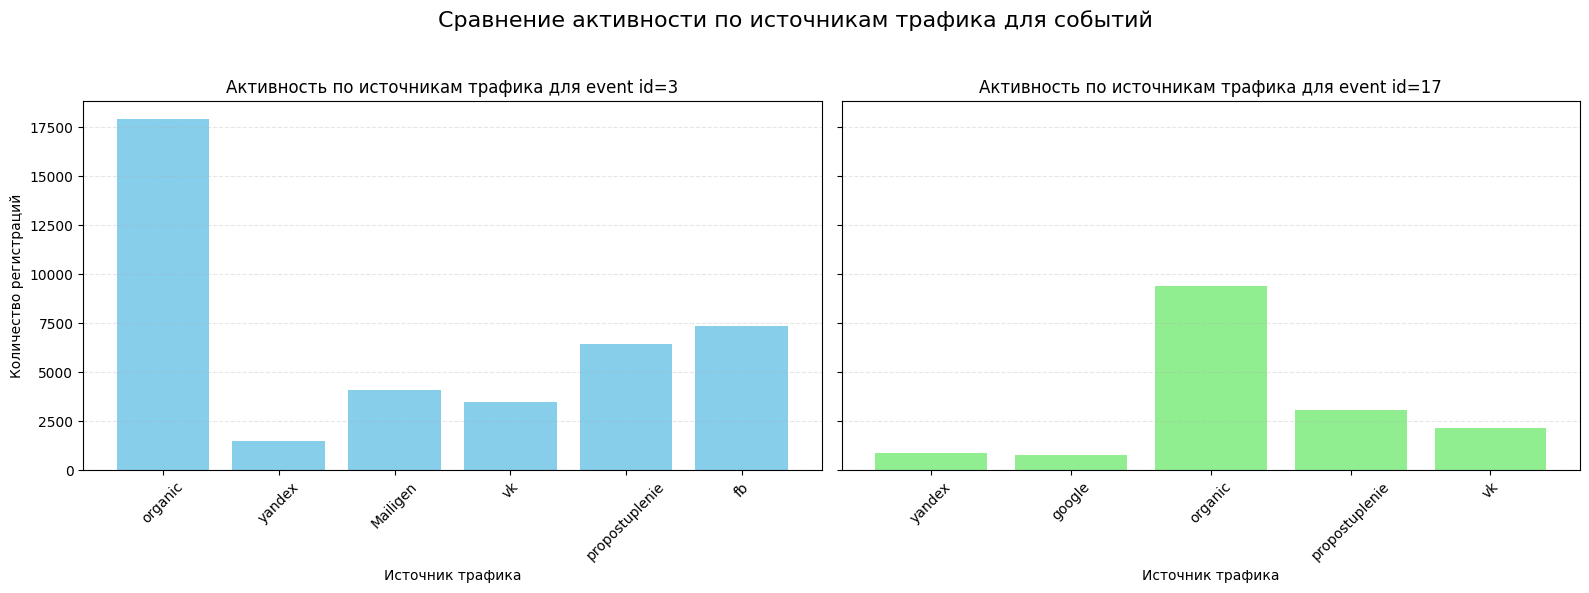

In [ ]:
c1 = 3
c2 = 17

df_event_3  = new_reg[new_reg['ExhibitionID'] == c1].copy() # можно менять цифры для сравнения/просмотра разных мероприятий
df_event_17 = new_reg[new_reg['ExhibitionID'] == c2].copy() # можно менять цифры для сравнения/просмотра разных мероприятий

lst = ['Registrations_count', 'Attendance']
what = lst[0] # выбрать: вывести график по активности регистраций либо по посещаемости

# Получаем данные для event id=3
df_3 = get_attendance(by='utm_source', df=df_event_3)

# Определяем порог для "Другое" на основе 2.5% от общего числа регистраций
border_3 = df_3['Registrations_count'].sum() * 0.025

# Суммируем мелкие группы
small_groups_3 = df_3[df_3['Registrations_count'] < border_3].sum()

# Убираем мелкие группы
df_3 = df_3[df_3['Registrations_count'] >= border_3]

# Сортируем по "Attendance" и выбираем топ-5
df_3 = df_3.sort_values(by='Attendance', ascending=False)
top_5_3 = df_3.iloc[:6]

# Все, что не попало в топ-5, добавляем в категорию "Другое"
if len(df_3) > 6:
    other_groups_3 = df_3.iloc[5:].sum()
    top_5_3.loc[len(top_5_3)] = [
        'Другое',
        other_groups_3['Registrations_count'],
        other_groups_3['Visits_count'],
        other_groups_3['Visits_count'] / other_groups_3['Registrations_count'] * 100,
    ]

# Сортируем итоговый DataFrame по "Attendance" в порядке убывания
top_5_3 = top_5_3.sort_values(by='Attendance', ascending=False)

# Среднее значение по "Attendance"
avg_attendance_3 = df_3['Attendance'].mean()

# Получаем данные для event id=17
df_17 = get_attendance(by='utm_source', df=df_event_17)

# Определяем порог для "Другое" на основе 2.5% от общего числа регистраций
border_17 = df_17['Registrations_count'].sum() * 0.025

# Суммируем мелкие группы
small_groups_17 = df_17[df_17['Registrations_count'] < border_17].sum()

# Убираем мелкие группы
df_17 = df_17[df_17['Registrations_count'] >= border_17]

# Сортируем по "Attendance" и выбираем топ-5
df_17 = df_17.sort_values(by='Attendance', ascending=False)
top_5_17 = df_17.iloc[:5]

# Все, что не попало в топ-5, добавляем в категорию "Другое"
if len(df_17) > 5:
    other_groups_17 = df_17.iloc[5:].sum()
    # Используем pd.concat для добавления новой строки
    other_row_17 = pd.DataFrame({
        'utm_source': ['Другое'],
        'Registrations_count': [other_groups_17['Registrations_count']],
        'Visits_count': [other_groups_17['Visits_count']],
        'Attendance': [other_groups_17['Visits_count'] / other_groups_17['Registrations_count'] * 100]
    })

# Сортируем итоговый DataFrame по "Attendance" в порядке убывания
top_5_17 = top_5_17.sort_values(by='Attendance', ascending=False)

# Среднее значение по "Attendance"
avg_attendance_17 = df_17['Attendance'].mean()

# Создаём графики на одном полотне
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Левый график: event id=3
axes[0].bar(top_5_3['utm_source'], top_5_3[what], color='skyblue') #Attendance
if what == 'Attendance':
    axes[0].axhline(y=avg_attendance_3, color='red', linestyle='--', label=f'Средняя: {avg_attendance_3:.2f}%')
if what == 'Attendance':
    axes[0].set_title(f'Посещаемость по источникам трафика для event id={c1}')
else:
    axes[0].set_title(f'Активность по источникам трафика для event id={c1}')
axes[0].set_xlabel('Источник трафика')
axes[0].set_ylabel('Количество регистраций')
if what == 'Attendance':
    axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Правый график: event id=17
axes[1].bar(top_5_17['utm_source'], top_5_17[what], color='lightgreen')
if what == 'Attendance':
    axes[1].axhline(y=avg_attendance_17, color='red', linestyle='--', label=f'Средняя: {avg_attendance_17:.2f}%')
if what == 'Attendance':
    axes[1].set_title(f'Посещаемость по источникам трафика для event id={c2}')
else:
    axes[1].set_title(f'Активность по источникам трафика для event id={c2}')
axes[1].set_xlabel('Источник трафика')
if what == 'Attendance':
    axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Устанавливаем общий заголовок
if what == 'Attendance':
    fig.suptitle('Сравнение посещаемости по источникам трафика для событий', fontsize=16)
else:
    fig.suptitle('Сравнение активности по источникам трафика для событий', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
if SAVE_ALL_PICTS:
    plt.savefig('p4.png', format='png', dpi=100, bbox_inches='tight')
display(top_5_3)
display(top_5_17)

**Что можно заметить:**
* У менее массовых мероприятий (15, 18 и 20) доминирующий источник трафика - фейсбук (на него приходится более половины всех заявок) при этом худший по доходимости трафик также фейсбук.
* У более массовых (3, 17) доминирующий источник трафика - органический, который также показывает хорошую доходимость

Рекомендации:
* Итак, видимо какая-то внешняя деятельность привлекает людей наиболее эффективно по соотношению массовости и доходимости. Рекомендуется назначить основным источником трафика органический и работать над улучшениями здесь в первую очередь.
* Также можно рассмотреть перенос рекламного трафика с соц сетей (вк, фейсбук) на поисковые платформы (яндекс, гугл). В целом ранее писала почему это может быть выгодно.

,utm_source,utm_medium,Registrations_count,Visits_count,Attendance,utm_source + utm_medium
18,organic,organic,17943,8804,49.066488,organic + organic
64,yandex,cpc,1462,715,48.905609,yandex + cpc
1,Mailigen,email,3980,1478,37.135678,Mailigen + email
37,propostuplenie,banner,6245,2138,34.235388,propostuplenie + banner
52,vk,cpc,1586,481,30.327869,vk + cpc
8,fb,cpa,7211,1766,24.490362,fb + cpa


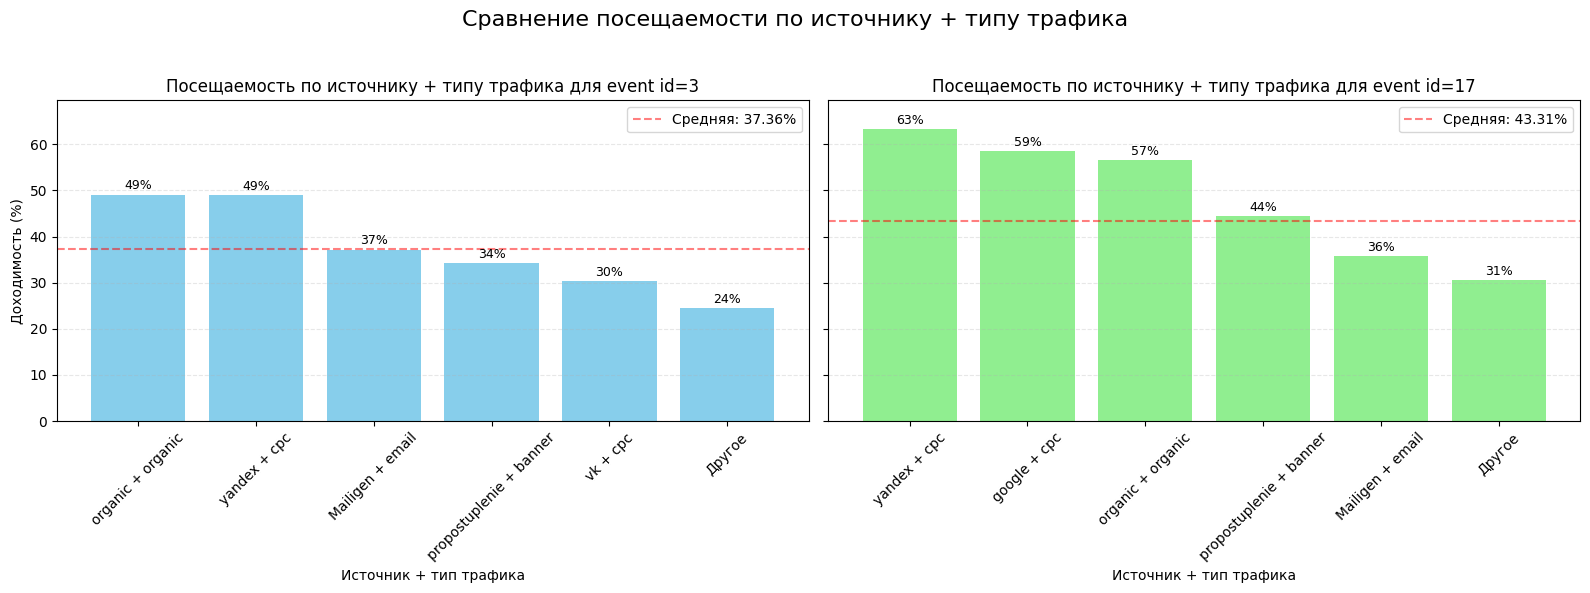

In [ ]:
# df_3, df_17 - зависят от c1, c2 из прошлой ячейки кода!

# Получение данных для event id=3
df_3 = get_attendance(by=['utm_source', 'utm_medium'], df=df_event_3)
df_3['utm_source + utm_medium'] = df_3['utm_source'] + ' + ' + df_3['utm_medium']
border_3 = df_3['Registrations_count'].sum() * 0.025
df_3 = df_3[df_3['Registrations_count'] >= border_3]
df_3 = df_3.sort_values(by='Attendance', ascending=False)


display(df_3)
# Создаём копию для top_5_3
top_5_3 = df_3.iloc[:5].copy()
if len(df_3) > 5:
    other_groups_3 = df_3.iloc[5:].sum()
    top_5_3.loc[len(top_5_3)] = [
        'Другое', 'Другое',
        other_groups_3['Registrations_count'],
        other_groups_3['Visits_count'],
        other_groups_3['Visits_count'] / other_groups_3['Registrations_count'] * 100,
        'Другое'
    ]
top_5_3 = top_5_3.sort_values(by='Attendance', ascending=False)

# Получение данных для event id=17
df_17 = get_attendance(by=['utm_source', 'utm_medium'], df=df_event_17)
df_17['utm_source + utm_medium'] = df_17['utm_source'] + ' + ' + df_17['utm_medium']
border_17 = df_17['Registrations_count'].sum() * 0.025
df_17 = df_17[df_17['Registrations_count'] >= border_17]
df_17 = df_17.sort_values(by='Attendance', ascending=False)

# Создаём копию для top_5_17
top_5_17 = df_17.iloc[:5].copy()
if len(df_17) > 5:
    other_groups_17 = df_17.iloc[5:].sum()
    top_5_17.loc[len(top_5_17)] = [
        'Другое', 'Другое',
        other_groups_17['Registrations_count'],
        other_groups_17['Visits_count'],
        other_groups_17['Visits_count'] / other_groups_17['Registrations_count'] * 100,
        'Другое'
    ]
top_5_17 = top_5_17.sort_values(by='Attendance', ascending=False)

# Среднее значение по "Attendance"
avg_attendance_3 = df_3['Attendance'].mean()
avg_attendance_17 = df_17['Attendance'].mean()
# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Левый график: event id=3
axes[0].axhline(y=avg_attendance_3, color='red', linestyle='--', label=f'Средняя: {avg_attendance_3:.2f}%', alpha=0.5) # Среднее
bars_3 = axes[0].bar(top_5_3['utm_source + utm_medium'], top_5_3['Attendance'], color='skyblue')
axes[0].set_title(f'Посещаемость по источнику + типу трафика для event id={c1}')
axes[0].set_xlabel('Источник + тип трафика')
axes[0].set_ylabel('Доходимость (%)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Добавляем проценты на график
max_height_3 = 0  # Максимальная высота столбца
for bar in bars_3:
    height = bar.get_height()
    max_height_3 = max(max_height_3, height)
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # Немного выше столбца
        f"{height:.0f}%",  # Процент
        ha='center', va='bottom', fontsize=9
    )
axes[0].set_ylim(0, max_height_3 * 1.1)  # Увеличиваем верхнюю границу

# Правый график: event id=17
axes[1].axhline(y=avg_attendance_17, color='red', linestyle='--', label=f'Средняя: {avg_attendance_17:.2f}%', alpha=0.5) # Среднее
bars_17 = axes[1].bar(top_5_17['utm_source + utm_medium'], top_5_17['Attendance'], color='lightgreen')
axes[1].set_title(f'Посещаемость по источнику + типу трафика для event id={c2}')
axes[1].set_xlabel('Источник + тип трафика')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Добавляем проценты на график
max_height_17 = 0  # Максимальная высота столбца
for bar in bars_17:
    height = bar.get_height()
    max_height_17 = max(max_height_17, height)
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # Немного выше столбца
        f"{height:.0f}%",  # Процент
        ha='center', va='bottom', fontsize=9
    )
axes[1].set_ylim(0, max_height_17 * 1.1)  # Увеличиваем верхнюю границу

# Устанавливаем общий заголовок
fig.suptitle('Сравнение посещаемости по источнику + типу трафика', fontsize=16)

# Подгоняем расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.95])


if SAVE_ALL_PICTS:
    plt.savefig('p5.png', format='png', dpi=100, bbox_inches='tight')

# Показываем графики
plt.show()


### 6. **Гипотеза 4**: Возможно источник трафика влияет на доходимость?

In [ ]:
new_reg['Attendance'] = new_reg.groupby(['utm_source', 'utm_medium'])['VisitID'].transform('count') / new_reg.groupby(['utm_source', 'utm_medium'])['RegistrationID'].transform('count') * 100

**Дизайн теста**:

**Цель теста** - проверить гипотезу о наличии статистической зависимости между источником трафика (utm_source) и доходимостью.

**Методика тестирования** - в качестве критерия используется непараметрический тест Краскала-Уоллиса с уровнем значимости 𝛼 = 0.01.

Если p-значение < 0.01, то гипотеза о независимости отклоняется, что указывает на статистически значимую зависимость. В противном случае гипотеза не отклоняется.

**Этапы тестирования**:

- Использовать категориальную переменную utm_source.
- Разделить выборки по уникальным значениям переменной utm_source.
- Проверить нормальность распределений в каждой группе с помощью теста Шапиро-Уилка. Если нормальность не выполняется для всех групп, применить тест Краскала-Уоллиса.
- Провести тест Краскала-Уоллиса для сравнения распределений доходимости между группами.

In [ ]:
from scipy.stats import shapiro, kruskal

# Сгруппировать данные по источнику трафика
sources = new_reg['utm_source'].unique()

# Создание списка данных для теста
data_for_test_by_source = [new_reg[new_reg['utm_source'] == source]['Attendance'] for source in sources]

# Проверка нормальности для каждого источника
for source in sources:
    group_data = new_reg[new_reg['utm_source'] == source]['Attendance']
    if len(group_data) >= 3:
        _, p_value = shapiro(group_data)

# Применение теста Краскала-Уоллиса, если нормальность не выполняется для всех групп
stat, p_value = kruskal(*data_for_test_by_source)

print(f"Статистика Краскала-Уоллиса: {stat}, p-value: {p_value}")

# Интерпретация результата
if p_value < 0.01:
    print("Доходимость зависит от источника трафика.")
else:
    print("Нет статистически значимых различий в доходимости по источникам трафика.")


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 30380.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8139.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 24022.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro

Статистика Краскала-Уоллиса: 86287.59508414363, p-value: 0.0
Доходимость зависит от источника трафика.


**Результаты тестирования**:
- Статистика теста Краскала-Уоллиса: 86287
- p-value ≈ 0.0

**Вывод**:

Так как p-value < 0.01, мы отвергаем нулевую гипотезу. Это означает, что существуют статистически значимые различия в доходимости между различными источниками трафика.

### 7. **Гипотеза 5**: Возможно тип рекламного канала влияет на доходимость?

**Дизайн теста**:

**Цель теста** - проверить гипотезу о наличии статистической зависимости между типом рекламного канала (utm_medium) и доходимостью.

**Методика тестирования** - в качестве критерия используется непараметрический тест Краскала-Уоллиса с уровнем значимости 𝛼 = 0.01.

Если p-значение < 0.01, то гипотеза о независимости отклоняется, что указывает на статистически значимую зависимость. В противном случае гипотеза не отклоняется.

**Этапы тестирования**:

- Выделить уникальные значения переменной utm_medium, представляющие типы рекламных каналов.
- Сгруппировать данные по переменной utm_medium, исключая группы с числом наблюдений менее 3.
- Провести тест Краскала-Уоллиса *(Тест Краскала-Уоллиса часто называют "ранговым аналогом Хи-квадрат-теста")* для сравнения распределений доходимости между группами.

In [ ]:
from scipy.stats import kruskal

# Применим тест Краскала-Уоллиса для рекламных каналов
channels = new_reg['utm_medium'].unique()

# Создаём список для передачи в тест
data_for_test = [new_reg[new_reg['utm_medium'] == channel]['Attendance'] for channel in channels if len(new_reg[new_reg['utm_medium'] == channel]) >= 3]

# Применяем тест Краскала-Уоллиса
h_stat, p_value = kruskal(*data_for_test)

print(f"Хи-квадрат статистика: {h_stat}, p-value: {p_value}")

# Интерпретация результата
if p_value < 0.01:
    print("Тип рекламного канала влияет на доходимость.")
else:
    print("Тип рекламного канала не влияет на доходимость.")


Хи-квадрат статистика: 77219.04315344561, p-value: 0.0
Тип рекламного канала влияет на доходимость.


**Результаты тестирования**:
- Статистика теста Краскала-Уоллиса: 77219
- p-value ≈ 0.0

**Вывод**:

Так как p-value < 0.01, мы отвергаем нулевую гипотезу, что означает, что существуют статистически значимые различия в доходимости между различными типами рекламных каналов. Это указывает на то, что тип рекламного канала влияет на доходимость участников мероприятий.

### 8. **Гипотеза 6**: Возможно, комбинация источника и канала влияет на доходимость участников мероприятий?

**Дизайн теста**:

**Цель теста** - проверить гипотезу о наличии статистической зависимости между комбинацией источника и канала (utm_source + utm_medium) и доходимостью.

**Методика тестирования** - в качестве критерия используется непараметрический тест Крускала-Уоллиса с уровнем значимости 𝛼 = 0.01.

Если p-значение < 0.01, то гипотеза о независимости отклоняется, что указывает на статистически значимую зависимость. В противном случае гипотеза не отклоняется.

**Этапы тестирования**:
- Использовать категориальную переменную utm_source + utm_medium
- Разделить выборки по уникальным значениям переменной utm_source + utm_medium
- Провести тест Крускала-Уоллиса для сравнения распределений доходимости между группами.


In [ ]:
from scipy.stats import shapiro, kruskal

# Комбинируем 'utm_source' и 'utm_medium' в одну переменную
new_reg['source_medium'] = new_reg['utm_source'] + ' ' + new_reg['utm_medium']

# Проверка на зависимость с помощью теста Крускала-Уоллиса
stat, p_value = stats.kruskal(*[new_reg[new_reg['source_medium'] == group]['Attendance']
                               for group in new_reg['source_medium'].unique()])

print(f"Статистика Крускала-Уоллиса: {stat}, p-value: {p_value}")

if p_value < 0.01:
    print("Есть статистическая зависимость между комбинацией источника и канала и доходимостью.")
else:
    print("Нет статистической зависимости.")


Статистика Крускала-Уоллиса: 89449.00000000001, p-value: 0.0
Есть статистическая зависимость между комбинацией источника и канала и доходимостью.


**Результаты тестирования**:

- Статистика Крускала-Уоллиса: 89449
- 𝑝-value ≈ 0.0

**Вывод**:

Так как 𝑝-значение < 0.01, результат теста является статистически значимым.
Существует зависимость между комбинацией источника и канала и доходимостью. Это означает, что доходимость варьируется в зависимости от источника трафика и канала привлечения.

Аналитика Юры:

1. **Производительность трафика по источникам и каналам**:
   - **Facebook (fb + cpa)** в обоих наборах данных имеет значительно высокие значения по количеству регистраций, однако его **доходимость** остаётся низкой (20.23 и 25.45). Это указывает на то, что Facebook привлекает много пользователей, но не все из них выполняют целевые действия.
   - **VK (vk + cpc)** также является источником с большим количеством регистраций и средним значением доходимости (25.16 и 24.94), что делает его менее эффективным по сравнению с более высокими результатами других источников.
   - **Propostuplenie (propostuplenie + banner)** показывает хорошую доходимость (37.75 и 37.70), что указывает на высокий отклик пользователей при более низких уровнях регистрации. Это может означать, что канал очень эффективен в привлечении пользователей.
   - **Organic (organic + organic)** также демонстрирует относительно высокую доходимость (37.75 и 24.45). Этот источник может быть наиболее эффективным.

2. **Тренды**:
   - Источник **organic** демонстрирует хорошие результаты в обоих наборах данных по соотношению доходимости и регистраций, что указывает на стабильность и высокую эффективность этого источника.
   - Рекламные источники, такие как **FB** и **VK**, в отличие от **organic** или **propostuplenie**, имеют более низкие показатели доходимости, что может указывать на необходимость оптимизации рекламных кампаний, так как высокая регистрация не часто трансформируется в действия.

3. **Рекомендации**:
   - **Рассмотреть увеличение бюджета на органический трафик (organic)**, так как он показывает отличное соотношение регистраций и доходимости. Это может помочь увеличить конверсию без значительного увеличения затрат на рекламу.
   - **Оптимизация рекламных каналов**. Для **Facebook** и **VK** стоит подумать о перераспределении бюджета, возможно, стоит тестировать различные рекламные стратегии (например, использование разных форматов рекламы или таргетинга) для повышения эффективности.
   - **Рассмотрение других форматов рекламы**. Например, **Propostuplenie + banner** показывают хорошие результаты по доходимости, несмотря на умеренные значения регистраций. Возможно, стоит увеличить внимание к этому каналу для повышения общей эффективности.
   - Важно учитывать как источник, так и канал трафика при планировании маркетинговых кампаний и анализе их эффективности. Комбинированное влияние этих факторов может быть полезным для оптимизации рекламных стратегий.

### Какие остаются задания (на мой взгляд):
1. Предложить свои гипотезы
2. Проверить гипотезы на статзначимость (какой стат критерий?)  
3. ~Сделать пункт 3.1 из рекомендаций (т.е. то же исследование доходимости, но отдельно для каждого мероприятия)~ ✔
4. ~Пункт 5 из рекомендаций с попарным сравнением (как я понимаю, нужно делать поправку на множественное исследование? а какой стат критерий?)~ ✔
5. ~Пункт 6 из рекомендаций~ ✔

Также пишите, если есть что добавить/посмотреть или с чем не согласны (в том числе по выводам).

Ну и другие ваши предложения.